In [1]:
import sys
sys.path.append('./../hyperAFM')
sys.path.append('./../Jessica')
sys.path.append('./../data')

import numpy as np
from util import HyperImage, load_ibw
from gen_features import get_hyper_peaks
from PCAsynthetic import makefeaturematrix, stdfeature
import FindPeaks 
#for standardizing 
from sklearn.preprocessing import scale

#PCA packages
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib.mlab import PCA

#linear regression package
from sklearn import linear_model 

#stats/math
import math
from scipy import stats 

#3-D plot
from mpl_toolkits.mplot3d import Axes3D

#import image alignment
from scipy import signal, optimize
from scipy.ndimage import rotate
from skimage.measure import compare_ssim as ssim
from skimage.feature import register_translation
from scipy.ndimage import fourier_shift
from scipy.optimize import minimize
from imagealignment import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import hyperspectral image 
hyperimage = HyperImage('./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0026.txt')
hyper = hyperimage.hyper_image
hypertopo = hyperimage.channel_data[:,:,0]
#flatten
hypertopo = signal.detrend(hypertopo, axis=1, type="linear")
wavelengths = hyperimage.wavelength_data

#import corresponding cAFM image
cAFMimage = load_ibw('./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/cAFM3_0000.ibw')
cAFMtopo = cAFMimage[:,:,0]
#flatten
cAFMtopo = signal.detrend(cAFMtopo, axis=1, type="linear")
cAFM = cAFMimage[:,:,3]
cAFMlist = cAFM.reshape((65536, 1))

In [4]:
hyperrot=rot(hyper, deg=-4)

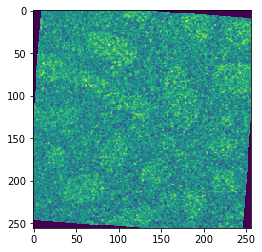

In [22]:
plt.imshow(hyperrot[:,:,237])

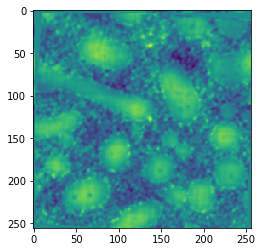

In [3]:
offimg_shift, offimg_rot, deg_opt, cAFMrot = shiftandrotate(hypertopo, cAFMtopo, cAFM, tol=1e-14)
plt.imshow(offimg_rot)

In [6]:
#see if deg_opt returns something reasonable after having shifted/rotated already 
deg_opt, error=optang(hypertopo, offimg_rot, guessang=1)
deg_opt

#subpixel -- ok. can it be better? 

array([-0.475])

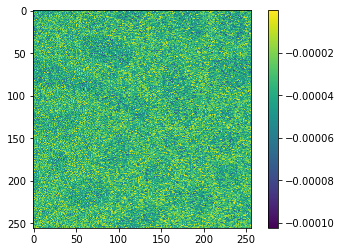

In [10]:
plt.imshow(cAFMrot-hyper[:,:,237])
plt.colorbar()

In [4]:
peaklocs, averagespectrum = get_hyper_peaks(hyper, threshold = 0.1)

array([ 62, 168, 199, 233, 294, 382, 418, 521], dtype=int64)

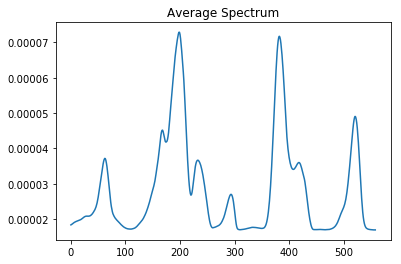

In [5]:
plt.plot(averagespectrum)
plt.title('Average Spectrum')
indices, peaksdict = FindPeaks.FindPeaks(averagespectrum, thres=0.1, min_dist=1)
indices

In [6]:
#standardize feature matrix to unit variance and zero mean 
featurematrix = makefeaturematrix(hyper, averagespectrum)
featurematrix_std = stdfeature(featurematrix, axis = 0)
mean = featurematrix_std.mean(axis=0)
variance = featurematrix_std.std(axis=0)
print(mean, variance)

(array([  9.26536307e-15,   1.28552501e-14,   1.07664816e-14,
        -3.04528944e-14,  -4.60071027e-16,   1.52243838e-15,
         2.08173068e-14,  -1.79396598e-14]), array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


In [7]:
#define number of principal components 
sklearn_pca = sklearnPCA(n_components=8)

#matrix with each sample in terms of the PCs
SkPC = sklearn_pca.fit_transform(featurematrix_std)

#covariance matrix 
Skcov = sklearn_pca.get_covariance()

#score matrix 
Skscore = sklearn_pca.score_samples(featurematrix_std)

#loadings
Skloadings = sklearn_pca.components_

#explained variance
Skvariance = sklearn_pca.explained_variance_
Skvarianceratio = sklearn_pca.explained_variance_ratio_

In [8]:
SkPCreshape = SkPC.reshape(256,256,8)

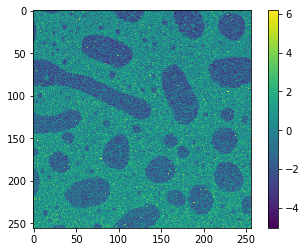

In [9]:
plt.imshow(SkPCreshape[:,:,0])
plt.colorbar()

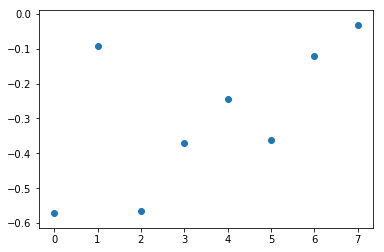

In [10]:
plt.scatter([0,1,2,3,4,5,6,7],Skloadings[0,:])

### Matlab's PCA 

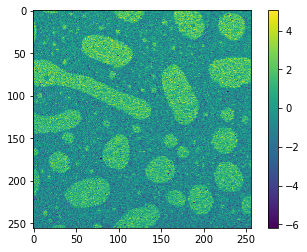

In [11]:
mlPCA = PCA(featurematrix_std)
#get projections of samples into PCA space
mltrans = mlPCA.Y
#reshape
mltransreshape = mltrans.reshape((256,256,8))
mlloadings = mlPCA.Wt

plt.imshow(mltransreshape[:,:,0])
plt.colorbar()

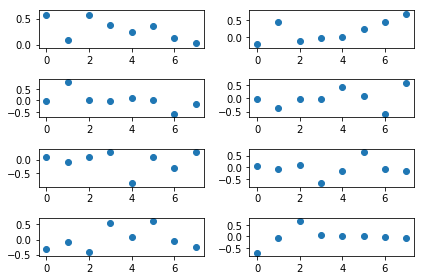

In [12]:
#show contributions from each peak to each principal component

x = [0, 1, 2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(nrows=4,ncols=2)

plt.subplot(4,2,1)
plt.scatter(x, mlloadings[0,:])

plt.subplot(4,2,2)
plt.scatter(x, mlloadings[1,:])

plt.subplot(4,2,3)
plt.scatter(x, mlloadings[2,:])

plt.subplot(4,2,4)
plt.scatter(x, mlloadings[3,:])

plt.subplot(4,2,5)
plt.scatter(x, mlloadings[4,:])

plt.subplot(4,2,6)
plt.scatter(x, mlloadings[5,:])

plt.subplot(4,2,7)
plt.scatter(x, mlloadings[6,:])

plt.subplot(4,2,8)
plt.scatter(x, mlloadings[7,:])

fig.tight_layout()
plt.show()

In [13]:
regr = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()

In [14]:
PC1 = mltransreshape[:,:,0] 
PC1list = PC1.reshape((65536,))
PC2 = mltransreshape[:,:,1]
PC2list = PC2.reshape((65536,))
PC3 = mltransreshape[:,:,2]
PC3list = PC3.reshape((65536,))
PC4 = mltransreshape[:,:,3]
PC4list = PC4.reshape((65536,))
PC5 = mltransreshape[:,:,4]
PC5list = PC5.reshape((65536,))
PC6 = mltransreshape[:,:,5]
PC6list = PC6.reshape((65536,))
PC7 = mltransreshape[:,:,6]
PC7list = PC7.reshape((65536,))
PC8 = mltransreshape[:,:,7]
PC8list = PC8.reshape((65536,))

#get variables in appropriate format
d = {}
training_x = []
for x in range(5000, 65536): 
    d[x] = [PC1list[x], PC2list[x], PC3list[x], PC4list[x], PC5list[x], PC6list[x], PC7list[x], PC8list[x]]
    training_x.append(d[x])
training_x = np.stack(training_x, axis=0)

In [15]:
training_x.shape

(60536L, 8L)

In [16]:
regr.fit(training_x, cAFMlist[5000:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
#store intercepts and B values from regression
B0 = regr.intercept_

for i in range (1, 9): 
    vars()['B'+str(i)] = regr.coef_[0,i-1]


In [19]:
element = 2
cAFM_pred = B0 + B1*PC1list[element] + B2*PC2list[element] + B3*PC3list[element] + B4*PC4list[element] + \
    B5*PC5list[element] + B6*PC6list[element] +B7*PC7list[element] + B8*PC8list[element]

In [20]:
points = 65536
cAFM_predmatrix=np.zeros((points,1))

for i in range(0, points): 
    element = i
    
    cAFM_pred = B0 + B1*PC1list[element] + B2*PC2list[element] + B3*PC3list[element] + B4*PC4list[element] + \
    B5*PC5list[element] + B6*PC6list[element] +B7*PC7list[element] + B8*PC8list[element]
    
    cAFM_predmatrix[element] = cAFM_pred

cAFMreshaped= cAFM_predmatrix.reshape(256,256)

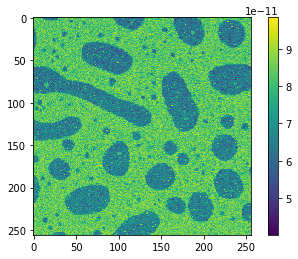

In [21]:
plt.imshow(cAFMreshaped)
plt.colorbar()

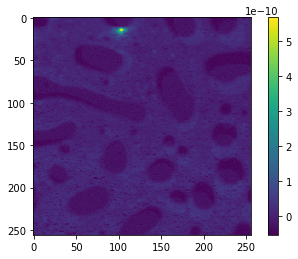

In [22]:
cAFMimage = cAFMlist.reshape((256,256))
cAFMerror = cAFMimage - cAFMreshaped
plt.imshow(cAFMerror)
plt.colorbar()

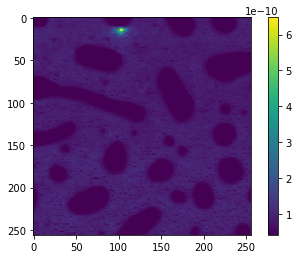

In [23]:
plt.imshow(cAFM)
plt.colorbar()

In [24]:
cAFM_pred=np.zeros((65536,))
cAFM_pred[1]

0.0

In [25]:
cAFM_predlist.reshape(256,256)

NameError: name 'cAFM_predlist' is not defined

In [26]:
cAFMlist[element]

array([  4.53618636e-11], dtype=float32)

In [27]:
cAFM_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

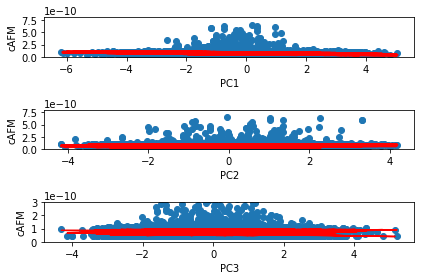

In [28]:
plt.subplot(311)
plt.scatter(PC1list,cAFMlist)
plt.plot(training_x[:,0],regr.predict(training_x),color='red',lw='3')
plt.ylabel('cAFM')
plt.xlabel('PC1')
plt.ylim(8e-15, 8e-10)

plt.subplot(312)
plt.scatter(PC2list,cAFMlist)
plt.plot(training_x[:,1],regr.predict(training_x),color='red',lw='3')
plt.ylabel('cAFM')
plt.xlabel('PC2')
plt.ylim(8e-20, 8e-10)

plt.subplot(313)
plt.scatter(PC3list,cAFMlist)
plt.plot(training_x[:,2],regr.predict(training_x),color='red')
plt.ylabel('cAFM')
plt.xlabel('PC3')
plt.ylim(8e-15, 3e-10)

plt.tight_layout()

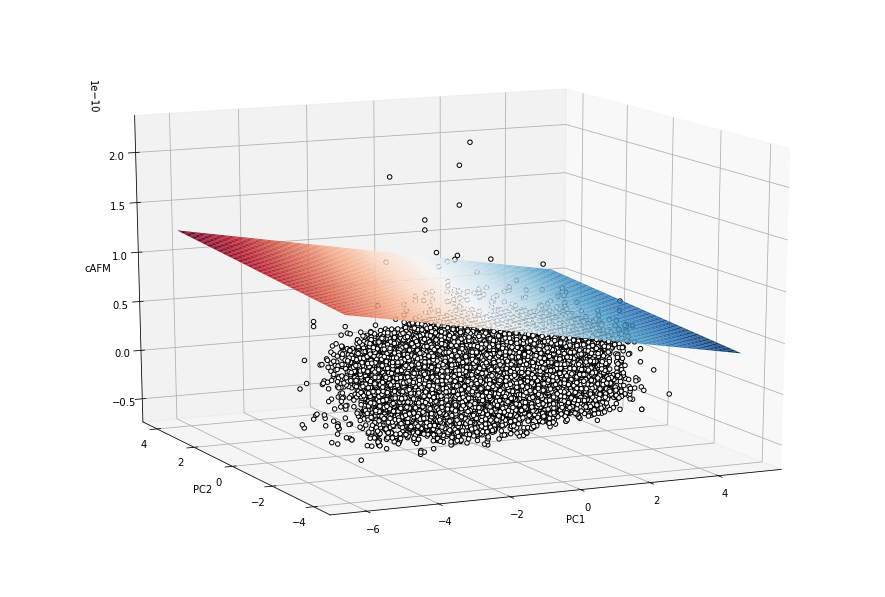

In [48]:
X1 = PC1list
X2 = PC2list
X = training_x[:,0:2]

xx1, xx2 = np.meshgrid(np.linspace(X1.min(), X1.max(), 200), 
                       np.linspace(X2.min(), X2.max(), 200))

z = B0 + B1*xx1 + B2*xx2

fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig, azim=-115, elev=15)

#hyperplane
surf = ax.plot_surface(xx1, xx2, z, cmap=plt.cm.RdBu_r)

resid = cAFMlist[5000:] - regr.predict(training_x)
newX = np.concatenate((X,resid),1)


ax.scatter(newX[:,0], newX[:,1], newX[:,2] , color='black', alpha=1.0, facecolor='white')
#ax.scatter(newX[:,0], newX[:,1], newX[:,2] < 0 , color='black', alpha=1.0)
#ax.scatter(X1, X2, cAFMlist, color='black', alpha=1.0, facecolor='white')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('cAFM')

F-statistic

In [192]:
predictors = 8
n = 60536
TSS = sum((cAFMlist[5000:] - cAFMlist[5000:].mean())**2)
RSS = sum((cAFMlist[5000:] - regr.predict(training_x))**2)
Fnumerator = (TSS-RSS)/predictors
Fdenominator = RSS/(n-predictors-1)
F= Fnumerator/Fdenominator
print(F)

[ 1775.21690306]


In [196]:
#RSS 
RSS = sum((cAFMlist[5000:]-regr.predict(training_x)**2))

#RSE
RSE = (math.sqrt(RSS/(n-2)))

#TSS 
TSS = sum(((cAFMlist[5000:]-cAFMlist[5000:].mean())**2))

#R^2 
Rsquared = (TSS-RSS)/TSS

#calculate standard errors
RSE=math.sqrt(RSS/(n-predictors-1))
SEB1=math.sqrt((RSE**2)*(1/n + PC1list[5000:].mean()**2)/sum(((PC1list[5000:]-PC1list[5000:].mean())**2)))
SEB2=math.sqrt((RSE**2)/(sum(((PC2list[5000:]-PC2list[5000:].mean())**2))))
SEB3=math.sqrt((RSE**2)/(sum(((PC3list[5000:]-PC3list[5000:].mean())**2))))

#use standard erros to get tstatistic so that we can get p-values for B_mass, VOC, and LUMO.
tB1=B1/SEB1
tB2=B2/SEB2
tB3=B3/SEB3

#calc p values:
pB1=stats.t.sf(np.abs(tB1), n-1)*2
pB2=stats.t.sf(np.abs(tB2), n-1)*2
pB3=stats.t.sf(np.abs(tB3), n-1)*2
print("P values are:", pB1, pB2, pB3)

('P values are:', 0.99072442458556265, 0.99995157011854818, 0.99999668128820574)


In [186]:
pB1

0.99072442458556265

In [148]:
cAFMlist[1]

array([  4.12443760e-11], dtype=float32)

In [149]:
cAFMlist[4]

array([  4.12992106e-11], dtype=float32)